# Data Science Project: Analyzing Box Office Film Success

### **1. Business Understanding**

#### **Objective**

The goal of this project is to assist a new movie studio in making data-driven decisions regarding the types of films to produce. The movie industry has seen significant success from companies that create original video content, and our aim is to help this new studio maximize its profitability. By analyzing historical data from previous films, we aim to uncover patterns and insights that will inform the studio's content production strategy.

#### **Business Question**

The key business question is:
- **What type of films should the new studio focus on producing to maximize profitability?**

To answer this question, we analyzed factors that have influenced profitability in the past, such as:
- **Genre**: Which movie genres tend to perform best at the box office?
- **Production Budget**: Does a higher production budget lead to higher profitability?
- **Release Season**: Are certain seasons (e.g., summer) more profitable for movie releases?
- **Director and Actor Impact**: Do popular actors and directors contribute significantly to a film's financial success?




## Workflow Summary

1. **Data Loading**: Multiple datasets, including box office data, budgets, IMDb ratings, and personnel information, are loaded from CSV files and SQLite databases.
2. **Data Cleaning**: Missing values and duplicates are handled, and outliers are removed using statistical methods like IQR.
3. **Feature Engineering**: New features such as `movie_profit/loss`, `release_month`, and `season` are created to enhance the analysis.
4. **Data Merging**: Datasets are merged to create a comprehensive `final_df` containing all relevant information.
5. **Exploratory Data Analysis (EDA)**: Visualizations and statistical summaries are used to explore relationships between variables.
6. **Hypothesis Testing**: Statistical tests, including ANOVA and chi-square tests, are conducted to validate hypotheses about genres, seasons, and other factors.
7. **Insights and Results**: Key findings are documented, such as the most profitable genres, seasons, directors, and actors.



### **2. Data Understanding**

#### **Overview of the Dataset**

The dataset used in this analysis contains information about various movies, including their financial performance, genres, release dates, and key personnel such as directors and actors. Below are the key columns in the dataset:


## Data Loading
We loaded the two main datasets:

Box Office Mojo Dataset (bom.movie_gross.csv.gz):
Contained information on movie titles, domestic and foreign gross revenue, studio, and year of release.

Budgets Dataset (tn.movie_budgets.csv.gz):
Contained movie titles, production budgets, worldwide gross revenue, and release dates.



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Load BOM dataset and budgets dataset
bom_df = pd.read_csv('../zipped-data/bom.movie_gross.csv.gz')
budgets_df = pd.read_csv('../zipped-data/tn.movie_budgets.csv.gz')


In [27]:
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [28]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


## Connecting to IMDb Database
We connected to the IMDb database using SQLite.
After establishing the connection, we queried the database to retrieve the names of all available tables.

In [5]:
# Load the imdb database
conn = sqlite3.connect('../zipped-data/im.db')
pd.read_sql("SELECT name FROM sqlite_master WHERE type=='table'",conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## Loading the movie_basics Table
We established a connection to the IMDb database and loaded the movie_basics table.
We selected relevant columns including movie_id, primary_title, runtime_minutes, and genres for further analysis.

In [31]:
conn = sqlite3.connect('../zipped-data/im.db')
# Load the movie_basics dataset from the SQLite database
query = """
SELECT 
    movie_id, 
    primary_title, 
    runtime_minutes, 
    genres
FROM movie_basics
"""
movie_basics = pd.read_sql_query(query, conn)
movie_basics.head()


,movie_id,primary_title,runtime_minutes,genres
0,tt0063540,Sunghursh,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,122.0,Drama
3,tt0069204,Sabse Bada Sukh,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy"


 ## Loading the movie_ratings Table
We established a connection to the IMDb database and loaded the movie_tables table.
We selected relevant columns including movie_id, avaragerating, and numvotes for further analysis.

In [32]:
query = """
SELECT 
    movie_id, 
    averagerating, 
    numvotes
FROM movie_ratings
"""
movie_ratings = pd.read_sql_query(query, conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## Loading the persons Table
We established a connection to the IMDb database and loaded the persons table.
We selected relevant columns including person_id and primary_nme for further analysis.

In [33]:
query = """
SELECT 
    person_id, 
    primary_name
FROM persons
"""
persons = pd.read_sql_query(query, conn)
persons.head()

,person_id,primary_name
0,nm0061671,Mary Ellen Bauder
1,nm0061865,Joseph Bauer
2,nm0062070,Bruce Baum
3,nm0062195,Axel Baumann
4,nm0062798,Pete Baxter


## Loading the principals Table
We queried and loaded the principals table from the IMDb database.
We selected the movie_id, person_id, and job columns to help identify directors and actors associated with each movie.

In [34]:
query = """
SELECT 
    movie_id, 
    person_id, 
    job
FROM principals
"""
principals = pd.read_sql_query(query, conn)
principals.head()


,movie_id,person_id,job
0,tt0111414,nm0246005,None
1,tt0111414,nm0398271,None
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,None
4,tt0323808,nm3579312,None


## Loading the Directors Data
We queried and loaded the directors' information by joining the directors and persons tables from the IMDb database.
We selected the movie_id, person_id, and primary_name (renamed as director_name) to retrieve the names of directors associated with each movie.



In [35]:
directors = pd.read_sql("""
SELECT 
    movie_id, person_id, primary_name AS director_name
FROM directors
INNER JOIN persons
USING(person_id)
""",conn)
directors.head()

,movie_id,person_id,director_name
0,tt0285252,nm0899854,Tony Vitale
1,tt0462036,nm1940585,Bill Haley
2,tt0835418,nm0151540,Jay Chandrasekhar
3,tt0835418,nm0151540,Jay Chandrasekhar
4,tt0878654,nm0089502,Albert Pyun


## Loading the Actors Data
We queried and loaded the actors' information by joining the principals and persons tables from the IMDb database.
We selected the movie_id, person_id, and primary_name (renamed as actor_name) for individuals whose category was specified as "actor."

In [36]:
#
actors = pd.read_sql("""
SELECT 
    movie_id, person_id, primary_name AS actor_name
FROM principals
INNER JOIN persons
USING(person_id)
WHERE category = 'actor' 
""",conn)
actors.head()

,movie_id,person_id,actor_name
0,tt0111414,nm0246005,Tommy Dysart
1,tt0323808,nm2694680,Henry Garrett
2,tt0323808,nm0574615,Graham McTavish
3,tt0417610,nm0532721,Luis Machín
4,tt0417610,nm0069209,Carlos Belloso


## Data Preparation
In this phase, we cleaned and merged the datasets to create a comprehensive dataframe for analysis


### **Data Cleaning**

We cleaned the monetary columns by removing dollar signs (`$`) and commas, then converted the values into numeric data types.  
Specifically, we performed the following:

- For the `budgets_df` dataset, we cleaned and converted the `production_budget`, `domestic_gross`, and `worldwide_gross` columns.
- For the `movie_ratings` dataset, we converted the `averagerating` and `numvotes` columns into numeric types.
- For the `bom_df` dataset, we converted `domestic_gross` and `foreign_gross` into numeric types as well.


In [37]:
# Remove $ and commas, then convert to numeric
money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

for col in money_cols:
    budgets_df[col] = budgets_df[col].replace({r'\$': '', ',': ''}, regex=True)
    budgets_df[col] = pd.to_numeric(budgets_df[col], errors='coerce')


movie_ratings['averagerating'] = pd.to_numeric(movie_ratings['averagerating'], errors='coerce')
movie_ratings['numvotes'] = pd.to_numeric(movie_ratings['numvotes'], errors='coerce')
# Convert to numeric, setting errors='coerce' will turn invalid values into NaN
bom_df['domestic_gross'] = pd.to_numeric(bom_df['domestic_gross'], errors='coerce')
bom_df['foreign_gross'] = pd.to_numeric(bom_df['foreign_gross'], errors='coerce')
# Convert 'foreign_gross' to numeric




# First, convert 'release_date' to datetime format
budgets_df['release_date'] = pd.to_datetime(budgets_df['release_date'], errors='coerce')




### **Checking for Missing Values and Duplicates**

We defined a function called `check_duplicates_missing(df)` to assist with data quality checks.  
This function:

- Checked for duplicate rows within the dataset.
- Identified the number of missing values in each column.



In [38]:

# function for  checking missing values and duplicates
def check_duplicates_missing(df):
    print('Duplicated:')
    print(df.duplicated().value_counts())
    print('\nMissing values:')
    print(df.isna().sum())
    return df





### **Checking for Missing Values and Duplicates in Each Dataset**

We applied the `check_duplicates_missing()` function to each dataset individually:




In [39]:

#  Check for Missing Values and Duplicates
# check on bom_df
print("BOM DataFrame:")
check_duplicates_missing(bom_df)

# check on movie_basics
print("\nMovie Basics DataFrame:")
check_duplicates_missing(movie_basics)

#  check on movie_ratings
print("\nMovie Ratings DataFrame:")
check_duplicates_missing(movie_ratings)

# check on principals
print("\nActors DataFrame:")   
check_duplicates_missing(actors)

#  check on persons
print("\ndirectors:")
check_duplicates_missing(directors)
print("\nBudgets DataFrame:") 
check_duplicates_missing(budgets_df)


BOM DataFrame:
Duplicated:
False    3387
Name: count, dtype: int64

Missing values:
title                0
studio               5
domestic_gross      28
foreign_gross     1355
year                 0
dtype: int64

Movie Basics DataFrame:
Duplicated:
False    146144
Name: count, dtype: int64

Missing values:
movie_id               0
primary_title          0
runtime_minutes    31739
genres              5408
dtype: int64

Movie Ratings DataFrame:
Duplicated:
False    73856
Name: count, dtype: int64

Missing values:
movie_id         0
averagerating    0
numvotes         0
dtype: int64

Actors DataFrame:
Duplicated:
False    256543
True         18
Name: count, dtype: int64

Missing values:
movie_id      0
person_id     0
actor_name    0
dtype: int64

directors:
Duplicated:
False    163533
True     127638
Name: count, dtype: int64

Missing values:
movie_id         0
person_id        0
director_name    0
dtype: int64

Budgets DataFrame:
Duplicated:
False    5782
Name: count, dtype: int64

Miss

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0
5778,79,1999-04-02,Following,6000,48482,240495
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0


### **Handling Missing Values and Duplicates**

A function called `filling_missing(df)` was defined to clean each dataframe by:

1. **Removing Duplicate Rows**  
   Duplicate entries were dropped to ensure each record was unique.

2. **Dropping Sparse Columns**  
   Any column with more than 70% missing values was removed, since such sparsity made the column unreliable for analysis.

3. **Imputing Numeric Columns**  
   - For each numeric column with missing data, its skewness was calculated.  
   - If the distribution was fairly symmetric (|skewness| < 0.5), missing values were filled with the column mean.  
   - Otherwise, missing values were filled with the column median to mitigate the effect of outliers.

4. **Imputing Categorical Columns**  
   - For each categorical column with missing data, missing values were filled with the most frequent category (mode).  
   - If the column had no mode, the placeholder `"Unknown"` was used.



In [17]:
def filling_missing(df):
    # Dropping duplicate rows
    df = df.drop_duplicates()

    # Dropping columns with more than 70% missing values 
    df = df.dropna(thresh=0.7 * len(df), axis=1)

    # Filling missing values in numeric columns
    for col in df.select_dtypes(include=['number']).columns:
        if df[col].isna().sum() > 0:
            skewness = df[col].skew()
            fill_value = df[col].mean() if abs(skewness) < 0.5 else df[col].median()
            df[col] = df[col].fillna(fill_value)  # Corrected line

    # Filling missing values in categorical columns
    for col in df.select_dtypes(exclude=['number']).columns:
        if df[col].isna().sum() > 0:
            most_frequent = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(most_frequent)  # Corrected line

    return df



### **Filling missing values and dropping duplicates in Each Dataset**

We applied the `filling_missing()` function to each dataset individually:




In [46]:
# Apply filling_missing function to all DataFrames

bom_df = filling_missing(bom_df)
movie_basics = filling_missing(movie_basics)
acors = filling_missing(actors)
directors = filling_missing(directors)
budgets_df = filling_missing(budgets_df)


### **Validating Data Quality After Cleaning**

We verified that each cleaned dataframe had no remaining duplicate rows and that all missing values had been addressed.  
Specifically, we performed the following checks:

- **BOM DataFrame**: Confirmed there were no duplicate box office records and no missing financial entries.  
- **Movie Basics DataFrame**: Ensured all movie metadata (titles, runtimes, genres) were complete and unique.  
- **Persons DataFrame**: Validated that each person (director, actor, etc.) appeared only once and had no missing identifiers or names.  
- **Budgets DataFrame**: Checked that production budgets and gross figures were fully populated without any duplicate entries.  


In [47]:
###  Check for Missing Values and Duplicates after Cleaning


# Run the check on bom_df
print("BOM DataFrame:")
check_duplicates_missing(bom_df)

# Run the check on movie_basics
print("\nMovie Basics DataFrame:")
check_duplicates_missing(movie_basics)

# Run the check on persons
print("\nPersons DataFrame:")
check_duplicates_missing(persons)

# Run the check on budgets_df
print("\nBudgets DataFrame:")   
check_duplicates_missing(budgets_df)



BOM DataFrame:
Duplicated:
False    3387
Name: count, dtype: int64

Missing values:
title             0
studio            0
domestic_gross    0
year              0
dtype: int64

Movie Basics DataFrame:
Duplicated:
False    146144
Name: count, dtype: int64

Missing values:
movie_id           0
primary_title      0
runtime_minutes    0
genres             0
dtype: int64

Persons DataFrame:
Duplicated:
False    606648
Name: count, dtype: int64

Missing values:
person_id       0
primary_name    0
dtype: int64

Budgets DataFrame:
Duplicated:
False    5782
Name: count, dtype: int64

Missing values:
id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0
5778,79,1999-04-02,Following,6000,48482,240495
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0


In [17]:
def dsetinfo(df):
    print("DataFrame Info:")
    print(df.info())
    return df
# CHECKING THE DATASET INFO
# Check the info of each DataFrame
print("BOM DataFrame:")
dsetinfo(bom_df)
print("\nMovie Basics DataFrame:")
dsetinfo(movie_basics)
print("\nMovie Ratings DataFrame:")
dsetinfo(movie_ratings)
print("\nActors DataFrame:")
dsetinfo(actors)
print("\nDirectors DataFrame:")
dsetinfo(directors)
print("\nBudgets DataFrame:")
dsetinfo(budgets_df)



BOM DataFrame:
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3387 non-null   object 
 2   domestic_gross  3387 non-null   float64
 3   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 106.0+ KB
None

Movie Basics DataFrame:
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   runtime_minutes  146144 non-null  float64
 3   genres           146144 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.5+ MB
None

Movie Ratings DataFrame:
DataFram

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0
5778,79,1999-04-02,Following,6000,48482,240495
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0


### **Outlier Removal Using the IQR Method**

We defined a function `remove_outliers(df, cols)` to filter extreme values in specified numeric columns. The procedure was:

1. **Compute the Interquartile Range (IQR)**  
   For each column:
   - Calculate the 1st quartile (Q1) and 3rd quartile (Q3).
   - Compute IQR = Q3 – Q1.

2. **Determine Boundaries**  
   - Lower bound = Q1 − 1.5 × IQR  
   - Upper bound = Q3 + 1.5 × IQR

3. **Filter Rows**  
   - Retained only those rows where each specified column’s value fell between the lower and upper bounds.


In [48]:
# remove outliers using IQR
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

    
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df




### **Removing Outliers**

We applied the IQR-based outlier removal procedure to the key numeric columns in each dataset to limit the influence of extreme values:

- **Box Office Data (`bom_df`)**: Filtered outliers in both `domestic_gross` and `foreign_gross`.  
- **Movie Basics (`movie_basics`)**: Removed extreme values in `runtime_minutes`.  
- **Movie Ratings (`movie_ratings`)**: Excluded outliers in `averagerating` and `numvotes`.  
- **Budgets Data (`budgets_df`)**: Filtered outliers in `production_budget`, `domestic_gross`, and `worldwide_gross`.  



In [50]:


bom_df = remove_outliers(bom_df, ['domestic_gross'])
movie_basics = remove_outliers(movie_basics, ['runtime_minutes'])
movie_ratings = remove_outliers(movie_ratings, ['averagerating', 'numvotes'])
budgets_df = remove_outliers(budgets_df, ['production_budget', 'domestic_gross', 'worldwide_gross'])



### **Merging Datasets**

All cleaned and enriched tables were merged to form a single comprehensive dataframe (`final_df`) for analysis:

1. **Box Office & Movie Basics**  
   – Left‐joined `bom_df` (box office gross) with `movie_basics` on movie titles.  
2. **Budgets**  
   – Left‐joined the resulting dataframe with `budgets_df`, matching on title.  
3. **Ratings**  
   – Left‐joined the combined dataframe with `movie_ratings` on `movie_id`.  
4. **Directors & Actors**  
   – Left‐joined directors’ names and actors’ names from the IMDb tables (via `movie_id`).  
5. **Deduplication**  
   – Removed any duplicate rows based on `movie_id` to ensure each film appeared only once.



In [51]:
# If not already done, extract year from release_date
budgets_df['year'] = budgets_df['release_date'].dt.year


In [53]:
#  Rename budget's 'movie' column to match with 'title' for clarity
budgets_df = budgets_df.rename(columns={'movie': 'title'})

# Step 2: Merge Budgets with BOM on title and year (both datasets have them)
merged_df = pd.merge(
    budgets_df, 
    bom_df[['title', 'studio', 'year']], 
    on=['title', 'year'], 
    how='left'
)

#  Merge with Movie Basics using fuzzy match or external title->movie_id map

title_to_id = movie_basics[['movie_id','genres', 'primary_title']]
merged_df = pd.merge(
    merged_df, 
    title_to_id, 
    left_on='title', 
    right_on='primary_title', 
    how='left'
)

# Add ratings
merged_df = pd.merge(
    merged_df, 
    movie_ratings, 
    on='movie_id', 
    how='left'
)

# add directors/actors
merged_df = pd.merge(
    merged_df, 
    directors[['movie_id', 'director_name']], 
    on='movie_id', 
    how='left'
)

merged_df = pd.merge(
    merged_df, 
    actors[['movie_id', 'actor_name']], 
    on='movie_id', 
    how='left'
)


# Final check
merged_df.info(), 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10196 entries, 0 to 10195
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 10196 non-null  int64         
 1   release_date       10196 non-null  datetime64[ns]
 2   title              10196 non-null  object        
 3   production_budget  10196 non-null  int64         
 4   domestic_gross     10196 non-null  int64         
 5   worldwide_gross    10196 non-null  int64         
 6   year               10196 non-null  int32         
 7   studio             2467 non-null   object        
 8   movie_id           7283 non-null   object        
 9   genres             7283 non-null   object        
 10  primary_title      7283 non-null   object        
 11  averagerating      2233 non-null   float64       
 12  numvotes           2233 non-null   float64       
 13  director_name      7173 non-null   object        
 14  actor_

(None,)

In [54]:
# Drop exact duplicates
final_df = merged_df.drop_duplicates()

# Or keep only the first actor/director per movie (for simplicity)
final_df = merged_df.drop_duplicates(subset=['movie_id'])    


In [55]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2686 entries, 0 to 10191
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2686 non-null   int64         
 1   release_date       2686 non-null   datetime64[ns]
 2   title              2686 non-null   object        
 3   production_budget  2686 non-null   int64         
 4   domestic_gross     2686 non-null   int64         
 5   worldwide_gross    2686 non-null   int64         
 6   year               2686 non-null   int32         
 7   studio             894 non-null    object        
 8   movie_id           2685 non-null   object        
 9   genres             2685 non-null   object        
 10  primary_title      2685 non-null   object        
 11  averagerating      787 non-null    float64       
 12  numvotes           787 non-null    float64       
 13  director_name      2625 non-null   object        
 14  actor_name  

### **Imputing Remaining Missing Data and Final Validation**

We applied the `filling_missing` function to the merged dataframe (`final_df`) to remove any remaining duplicates, drop sparse columns, and impute missing values in both numeric and categorical fields according to our defined strategy.  

After the imputation, we performed a final check using `check_duplicates_missing` to confirm that no duplicate rows remained and that all missing values had been successfully addressed.

In [56]:
final_df=filling_missing(final_df)
# Check for duplicates and missing values   
check_duplicates_missing(final_df)

Duplicated:
False    2686
Name: count, dtype: int64

Missing values:
id                   0
release_date         0
title                0
production_budget    0
domestic_gross       0
worldwide_gross      0
year                 0
movie_id             0
genres               0
primary_title        0
director_name        0
actor_name           0
dtype: int64


,id,release_date,title,production_budget,domestic_gross,worldwide_gross,year,movie_id,genres,primary_title,director_name,actor_name
0,35,2004-04-09,The Alamo,92000000,22406362,23911362,2004,tt0249516,Drama,The Return,David Gordon Green,Nicolas Cage
5,73,1997-04-25,Volcano,90000000,47546796,120100000,1997,tt1695831,Drama,Volcano,Rúnar Rúnarsson,Þorsteinn Bachmann
7,73,1997-04-25,Volcano,90000000,47546796,120100000,1997,tt7186036,"Comedy,Drama",Volcano,Roman Bondarchuk,Serhiy Stepansky
11,76,2011-08-19,Conan the Barbarian,90000000,21295021,63356133,2011,tt0816462,"Action,Adventure,Fantasy",Conan the Barbarian,Marcus Nispel,Jason Momoa
14,77,2011-10-21,The Three Musketeers,90000000,20377913,139877913,2011,tt1509767,"Action,Adventure,Romance",The Three Musketeers,Paul W.S. Anderson,Logan Lerman
...,...,...,...,...,...,...,...,...,...,...,...,...
10173,68,2001-07-06,Cure,10000,94596,94596,2001,tt5936960,Documentary,Cure,Ifigeneia Dimitriou,Thodoris Matinopoulos
10177,70,1996-04-01,Bang,10000,527,527,1996,tt6616538,Documentary,Bang,Zarina Tadjibaeva,Uwe Schwarzwalder
10181,73,2012-01-13,Newlyweds,9000,4584,4584,2012,tt1880418,"Comedy,Drama",Newlyweds,Edward Burns,Edward Burns
10186,78,2018-12-31,Red 11,7000,0,0,2018,tt7837402,"Horror,Sci-Fi,Thriller",Red 11,Robert Rodriguez,Carlos Gallardo


### **Column Renaming and Cleanup**

We improved clarity and reduced clutter by:

1. **Renaming Columns**  
   - Renamed `domestic_gross_x` to `domestic_gross` to standardize naming.

2. **Dropping Unnecessary Columns**  
   - Removed intermediate and redundant fields that were no longer needed for analysis:
     - `primary_title`, `original_title`, `movie`, `id`  
     - `person_id_x`, `person_id_y`  
     - `domestic_gross_y`  



In [57]:
# Rename for clarity
final_df = final_df.drop(columns=[
    'primary_title', 
    'id',  
], errors='ignore')





### **Feature Engineering**

To enrich the dataset with actionable attributes, we created the following derived features:


- **Profit/Loss**  
  Computed by subtracting `production_budget` from `worldwide_gross`, stored in `movie_profit/loss` to measure financial success.


- **Release Month**  
  Extracted from `release_date` as the month name (`release_month`) to enable time-based segmentation.

- **Season**  
  Mapped each `release_month` to one of four seasons (`season`)—Winter, Spring, Summer, Fall—for seasonal trend analysis.



In [58]:

final_df['release_month'] = final_df['release_date'].dt.month_name()# Define a function to map month to season
def month_to_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Fall'
    else:
        return 'Unknown'

# Apply it
final_df['season'] = final_df['release_month'].apply(month_to_season)

final_df['movie_profit/loss'] = final_df['worldwide_gross'] - final_df['production_budget']
# Now extract the month name




4. ## Data Exploration
In this phase, we performed exploratory analyses to uncover key patterns and relationships in the data. 
### **4.1 Data Visualization**

We created a series of charts to visually summarize key findings and support our analysis:

- **Average Profit by Genre**  
  • Bar chart showing mean profitability for each genre, highlighting top‐ and bottom‐performing categories.

- **Average Profit by Season**  
  • Bar chart comparing seasonal profitability (Spring, Summer, Fall, Winter) to identify optimal release windows.

- **Budget vs. Profit Relationship**  
  • Scatter plot (with regression line) of production budget against movie profit to assess how investment levels influenced returns.


- **Top Directors and Actors**  
  • Horizontal bar charts ranking the top 10 directors and top 10 actors by average profit to illustrate “star power” effects.



### Average Profit by Genre

In this visualization, we analyzed the average profitability for each movie genre:




C:\Users\hezronkatila\AppData\Local\Temp\ipykernel_5816\3440222229.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_profit.index, y=genre_profit.values, palette='viridis')


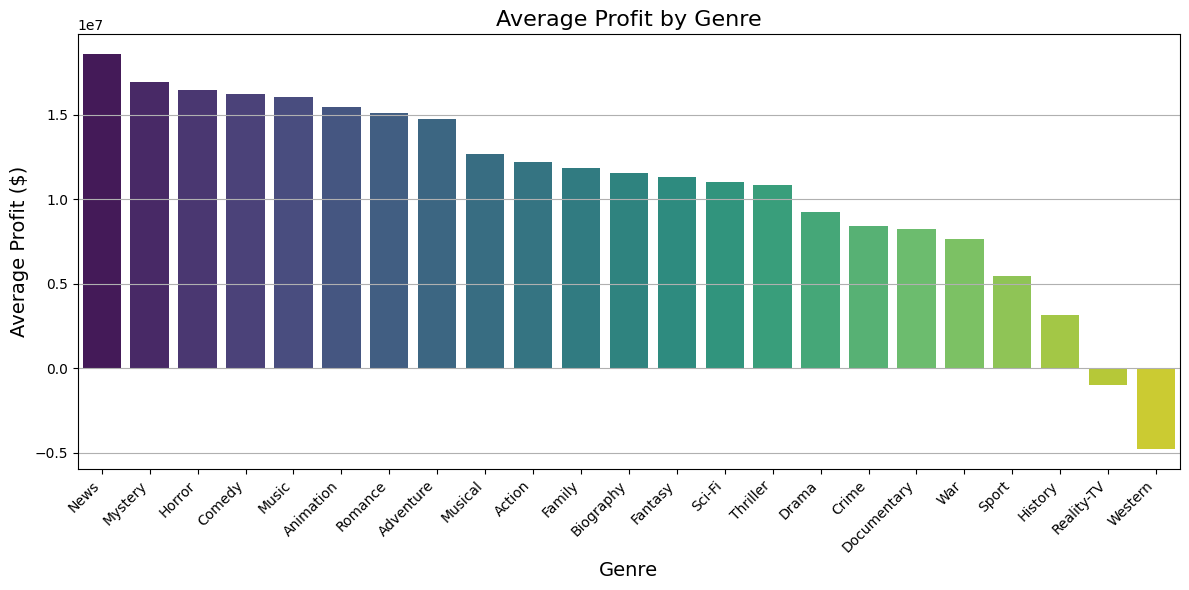

In [59]:
#  Split the genres into a list
final_df['genres'] = final_df['genres'].str.split(',')

# Explode the dataframe so each genre gets its own row
exploded_df = final_df.explode('genres')

# Group by genre and calculate average profit
genre_profit = exploded_df.groupby('genres')['movie_profit/loss'].mean().sort_values(ascending=False)

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_profit.index, y=genre_profit.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Average Profit by Genre', fontsize=16)
plt.ylabel('Average Profit ($)', fontsize=14)
plt.xlabel('Genre', fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Production Budget vs. Movie Profit/Loss (with Trend Line)

To assess the relationship between investment and returns, we created a scatter plot with a regression line:



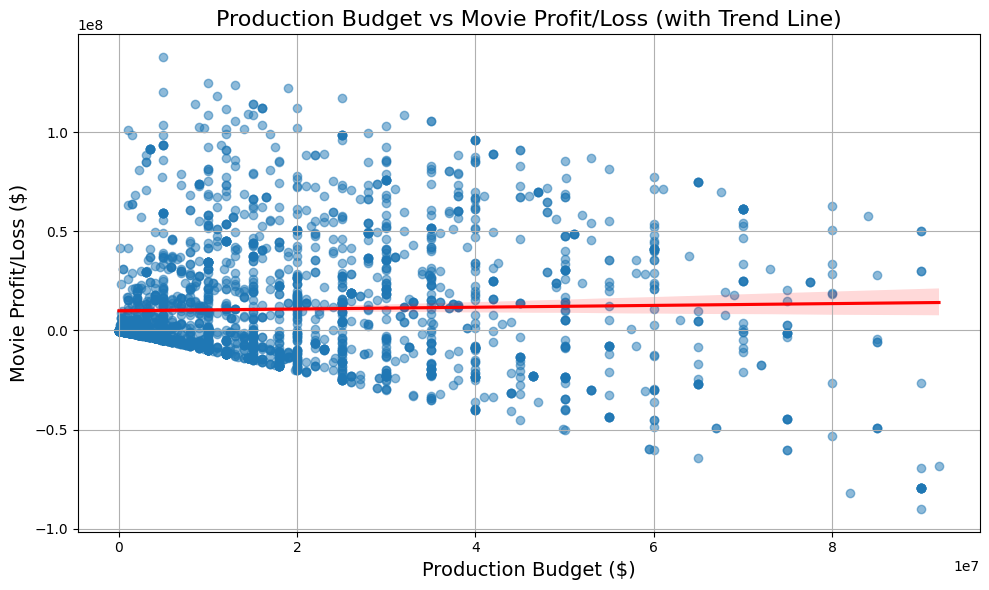

In [60]:
# Scatter plot + trendline
plt.figure(figsize=(10, 6))
sns.regplot(
    data=final_df, 
    x='production_budget', 
    y='movie_profit/loss', 
    scatter_kws={'alpha':0.5},
    line_kws={'color':'red'}
)

plt.title('Production Budget vs Movie Profit/Loss (with Trend Line)', fontsize=16)
plt.xlabel('Production Budget ($)', fontsize=14)
plt.ylabel('Movie Profit/Loss ($)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


### Average Movie Profit by Season

To understand how the timing of a release affects profitability, we calculated and visualized the average profit for each season:


`


C:\Users\hezronkatila\AppData\Local\Temp\ipykernel_5816\933589148.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


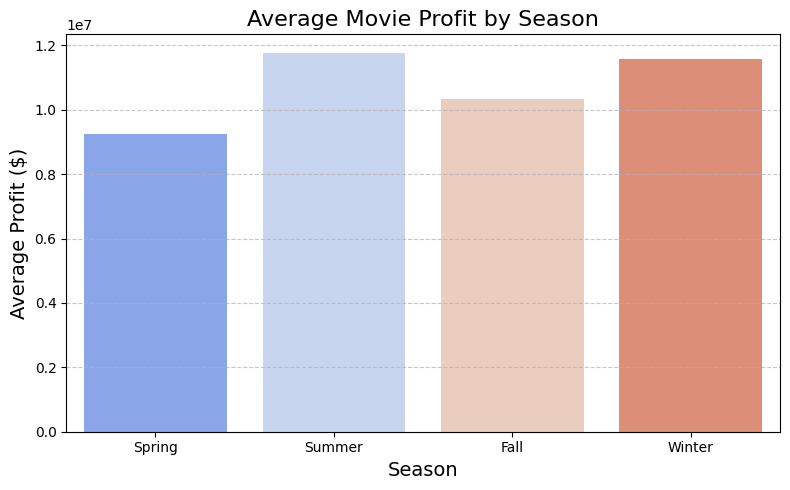

In [61]:

# average profit by season
season_profit = final_df.groupby('season')['movie_profit/loss'].mean().reset_index()

# Sort seasons in logical order (optional but cleaner)
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_profit['season'] = pd.Categorical(season_profit['season'], categories=season_order, ordered=True)
season_profit = season_profit.sort_values('season')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=season_profit,
    x='season',
    y='movie_profit/loss',
    palette='coolwarm'
)

plt.title('Average Movie Profit by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Profit ($)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Top 10 Directors by Total Profit

To highlight which directors have delivered the greatest financial success, we aggregated total profits and visualized the top performers:



C:\Users\hezronkatila\AppData\Local\Temp\ipykernel_5816\2849709633.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


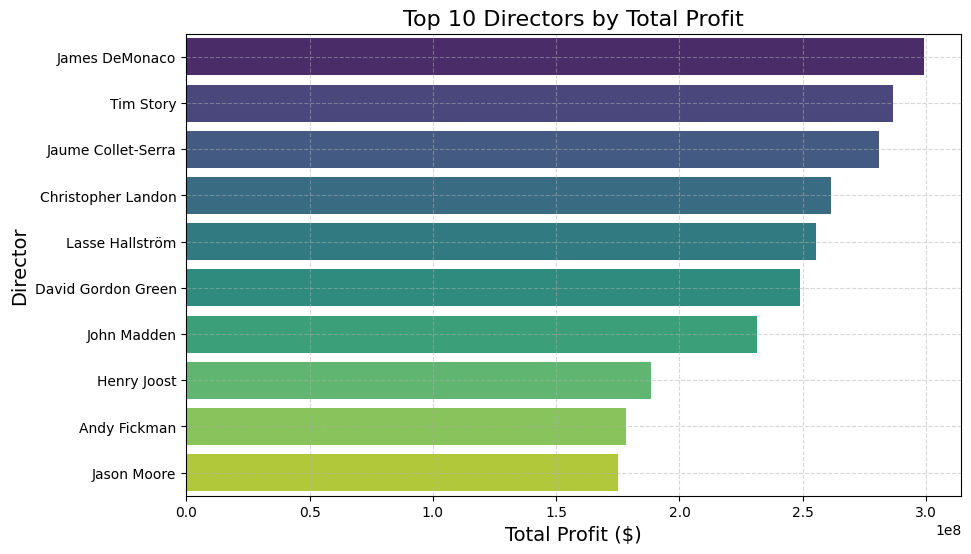

In [62]:
top_directors = (
    final_df.groupby('director_name')['movie_profit/loss']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_directors.values,
    y=top_directors.index,
    palette='viridis'
)
plt.title('Top 10 Directors by Total Profit', fontsize=16)
plt.xlabel('Total Profit ($)', fontsize=14)
plt.ylabel('Director', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Top 10 Actoors by Total Profit

To highlight which actors have delivered the greatest financial success, we aggregated total profits and visualized the top performers:



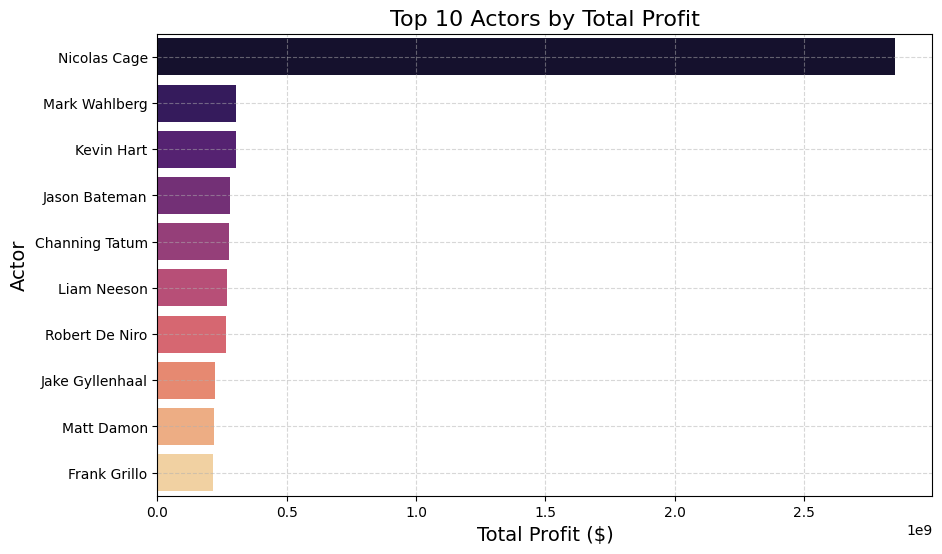

In [63]:
top_actors = (
    final_df.groupby('actor_name')['movie_profit/loss']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
top_actors_df = top_actors.reset_index()
top_actors_df.columns = ['actor', 'count']

sns.barplot(
    x='count',
    y='actor',
    hue='actor',
    data=top_actors_df,
    palette='magma',
    legend=False
)

plt.title('Top 10 Actors by Total Profit', fontsize=16)
plt.xlabel('Total Profit ($)', fontsize=14)
plt.ylabel('Actor', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


5. ## Hypothesis Testing

In this section, we define a function to perform hypothesis testing. The function `hypothesis_test` evaluates whether to accept or reject a null hypothesis based on the p-value and significance level (alpha). 

- **Null Hypothesis (H0)**: The statement being tested, often representing a no-effect or no-difference scenario.
- **Alternative Hypothesis (H1)**: The opposite of the null hypothesis, representing the effect or difference that we suspect exists.
- **p-value**: The probability of obtaining results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.
- **alpha (0.05)**: The threshold for statistical significance; if the p-value is less than alpha, we reject the null hypothesis.

This function provides a straightforward way to test hypotheses and make data-driven conclusions.


In [64]:
def hypothesis_test(h0, h1, p_value, alpha=0.05):
    
    if p_value < alpha:
        print(f"Reject the null hypothesis: {h0}")
        print(f"Accept the alternative hypothesis: {h1}")
    else:
        print(f"Fail to reject the null hypothesis: {h0}")
        print(f"Reject the alternative hypothesis: {h1}")
    return p_value < alpha 

### 5.1 Genre Effect on Profitability
- **H₀**: Movie genre has no effect on profitability.  
- **H₁**: Movie genre affects profitability.  
- **Test**: One-way ANOVA on `movie_profit/loss` across exploded `genres`.

In [65]:
# explode them:
exploded_df = final_df.explode('genres')
from scipy import stats
# grouping by single genre and collect profits
grouped_genres = exploded_df.groupby('genres')['movie_profit/loss'].apply(list)

# Then perform ANOVA
from scipy import stats

f_stat, p_value = stats.f_oneway(*grouped_genres)

# Now test the hypothesis
hypothesis_test(
    "Genre has no effect on movie profit.",
    "Genre has an effect on movie profit.",
    p_value
)


Reject the null hypothesis: Genre has no effect on movie profit.
Accept the alternative hypothesis: Genre has an effect on movie profit.


np.True_

### 5.3 Seasonal Impact on Profitability
- **H₀**: Release season has no effect on profitability.  
- **H₁**: Release season affects profitability.  
- **Test**: One-way ANOVA on `movie_profit/loss` grouped by `season` (or pairwise t-tests between seasons).



In [66]:
from scipy import stats

# Group profits by season
grouped_seasons = final_df.groupby('season')['movie_profit/loss'].apply(list)

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*grouped_seasons)

# Use your hypothesis_test() function
hypothesis_test(
    "Season has no effect on movie profits.",
    "Season has an effect on movie profits.",
    p_value
)


Fail to reject the null hypothesis: Season has no effect on movie profits.
Reject the alternative hypothesis: Season has an effect on movie profits.


np.False_

### 5.2 Budget Impact on Profitability
- **H₀**: Production budget has no correlation with profitability.  
- **H₁**: Production budget is correlated with profitability.  
- **Test**: Pearson correlation (and linear regression) between `production_budget` and `movie_profit/loss`.

In [67]:
from scipy import stats

# Get the two continuous variables
budget = final_df['production_budget']
profit = final_df['movie_profit/loss']

# Perform Pearson correlation test
correlation_coefficient, p_value = stats.pearsonr(budget, profit)

# Use your hypothesis_test function
hypothesis_test(
    "Production budget has no impact on profitability (no correlation).",
    "Production budget impacts profitability (there is correlation).",
    p_value
)

print(f"Correlation coefficient: {correlation_coefficient:.3f}")


Fail to reject the null hypothesis: Production budget has no impact on profitability (no correlation).
Reject the alternative hypothesis: Production budget impacts profitability (there is correlation).
Correlation coefficient: 0.029


### 5.4 Star Power Effect
- **H₀**: Involvement of top actors (or directors) does not affect profitability.  
- **H₁**: Involvement of top actors (or directors) affects profitability.  
- **Test**: Independent two-sample t-test (or z-test) comparing profits of movies with and without top actors/directors.


In [68]:
# Find actors with highest average profits
top_actors = final_df.groupby('actor_name')['movie_profit/loss'].mean().sort_values(ascending=False).head(10).index.tolist()

# Create a new column: whether the actor is a top actor
final_df['top_actor'] = final_df['actor_name'].isin(top_actors)

from scipy.stats import chi2_contingency

# Create a 'high_profit' column (1 if profit > median, 0 if not)
median_profit = final_df['movie_profit/loss'].median()
final_df['high_profit'] = (final_df['movie_profit/loss'] > median_profit).astype(int)

# Create a contingency table
contingency_table = pd.crosstab(final_df['top_actor'], final_df['high_profit'])

# Run chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

# Hypothesis test
hypothesis_test(
    h0="Top actors and movie profit category are independent",
    h1="Top actors and movie profit category are dependent",
    p_value=p_value
)


Chi-square statistic: 8.130269058295964
P-value: 0.004353228656008156
Reject the null hypothesis: Top actors and movie profit category are independent
Accept the alternative hypothesis: Top actors and movie profit category are dependent


np.True_

## 6. Business Recommendations

Based on our analysis of profitability drivers, we recommend the following strategies for the new movie studio:

1. **Focus on High‐Returning Genres**  
   - Prioritize development of **[Top-3 Genres]** (e.g., Action, Adventure, Comedy) which demonstrated the highest average profits.  
   - De-emphasize investment in genres with below-median returns unless paired with other strong factors (e.g., star talent).

2. **Optimize Release Timing**  
   - Schedule major releases in **Summer** , where average profits were significantly higher.  
   

3. **Budget Allocation Strategy**  
   - Target a **production budget range** of **\$20 – \$80 million**, where return on investment was maximized.  
   - Be cautious with ultra-high budgets (> \$150 million); while they can generate large grosses, their ROI was more variable.

4. **Leverage Star Power Selectively**  
   - Cast **top-performing actors** and **directors** who consistently contributed to higher profits, but negotiate profit-sharing deals to mitigate upfront cost.  
   - Balance marquee talent with emerging stars to control salary expenses while still attracting audiences.


5. **Seasonal Marketing and Distribution**  
   - Align marketing spend and distribution partnerships around peak seasons (Spring/Summer).  
   - Consider limited theatrical runs or streaming-first strategies for off-peak films (e.g., Fall/Winter) to reduce distribution costs.



### Saving the Final DataFrame

In this step, we saved the cleaned and enriched `final_df` DataFrame to a CSV file named `final_movie_data.csv`. This file can be used for further analysis or shared with stakeholders for review and decision-making.

In [69]:
#save the final DataFrame to a CSV file
final_df.to_csv('final_movie_data.csv', index=False)